In [2]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import torch.nn.functional as F
import random 
import tensorflow as tf 
from sklearn.metrics import roc_auc_score
import cv2
from torchvision.transforms.functional import to_pil_image, to_tensor

## Preparando o Dataset

In [3]:
data_dir = os.getcwd()
target_classes_full = ['Diabetic Wounds', 'Normal', 'Pressure Wounds', 'Venous Wounds']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# --- 1. Criação do DataFrame com Filtragem ---
def create_dataframe(data_dir, target_classes):
    data = []
    for label_idx, label_name in enumerate(target_classes):
        class_dir = os.path.join(data_dir, label_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if not img_file.startswith('mirrored_') and img_file.lower().endswith(('png', 'jpg', 'jpeg')):
                    data.append({'image_path': os.path.join(class_dir, img_file),
                                 'label_name': label_name,
                                 'label_idx': label_idx})
    return pd.DataFrame(data)

df_full = create_dataframe(data_dir, target_classes_full)

label_to_idx_full = {name: i for i, name in enumerate(target_classes_full)}
idx_to_label_full = {i: name for i, name in enumerate(target_classes_full)}
df_full['label_idx_original'] = df_full['label_name'].map(label_to_idx_full)


print(f"Total de imagens após filtrar 'mirrored_': {len(df_full)}")
print("Distribuição das classes originais:")
print(df_full['label_name'].value_counts())

Usando dispositivo: cpu
Total de imagens após filtrar 'mirrored_': 879
Distribuição das classes originais:
label_name
Pressure Wounds    301
Venous Wounds      247
Diabetic Wounds    231
Normal             100
Name: count, dtype: int64


In [4]:
# --- 2. Preparação dos Dados para Modelo de Dois Estágios ---

# Estágio 1: Normal vs. Ferida
# 'Normal' -> 0, 'Diabetic Wounds', 'Pressure Wounds', 'Venous Wounds' -> 1
df_s1 = df_full.copy()
df_s1['label_s1'] = df_s1['label_name'].apply(lambda x: 0 if x == 'Normal' else 1)
classes_s1 = ['Normal', 'Wound']

# Estágio 2: Classificação das Feridas (exclui 'Normal')
df_s2 = df_full[df_full['label_name'] != 'Normal'].copy()
s2_label_map = {label: i for i, label in enumerate(sorted(df_s2['label_name'].unique()))}
df_s2['label_s2'] = df_s2['label_name'].map(s2_label_map)
classes_s2 = sorted(list(s2_label_map.keys())) # ['Diabetic Wounds', 'Pressure Wounds', 'Venous Wounds']
idx_to_label_s2 = {i: name for name, i in s2_label_map.items()}


# Divisão Treino/Validação/Teste para Estágio 1
train_df_s1, test_df_s1 = train_test_split(df_s1, test_size=0.2, stratify=df_s1['label_s1'], random_state=42)
train_df_s1, val_df_s1 = train_test_split(train_df_s1, test_size=0.2, stratify=train_df_s1['label_s1'], random_state=42)

# Divisão Treino/Validação/Teste para Estágio 2
train_df_s2, test_df_s2 = train_test_split(df_s2, test_size=0.2, stratify=df_s2['label_s2'], random_state=42)
train_df_s2, val_df_s2 = train_test_split(train_df_s2, test_size=0.2, stratify=train_df_s2['label_s2'], random_state=42)

print(f"\nEstágio 1 - Treino: {len(train_df_s1)}, Validação: {len(val_df_s1)}, Teste: {len(test_df_s1)}")
print(f"Estágio 2 - Treino: {len(train_df_s2)}, Validação: {len(val_df_s2)}, Teste: {len(test_df_s2)}")


Estágio 1 - Treino: 562, Validação: 141, Teste: 176
Estágio 2 - Treino: 498, Validação: 125, Teste: 156


In [5]:
# --- 3. SEM Data Augmentation e Dataset Personalizado ---

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class WoundDataset(Dataset):
    def __init__(self, dataframe, image_col, label_col, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.image_col = image_col
        self.label_col = label_col

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx][self.image_col]
        label = self.dataframe.iloc[idx][self.label_col]
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            print(f"Erro: Imagem não encontrada em {img_path}")
            return None, None 
        except Exception as e:
            print(f"Erro ao abrir a imagem {img_path}: {e}")
            return None, None

        if self.transform:
            image = self.transform(image)
        
        return image, label, img_path

# DataLoaders para Estágio 1
train_dataset_s1 = WoundDataset(train_df_s1, 'image_path', 'label_s1', transform=val_test_transforms)
val_dataset_s1 = WoundDataset(val_df_s1, 'image_path', 'label_s1', transform=val_test_transforms)
test_dataset_s1 = WoundDataset(test_df_s1, 'image_path', 'label_s1', transform=val_test_transforms)

# DataLoaders para Estágio 2
train_dataset_s2 = WoundDataset(train_df_s2, 'image_path', 'label_s2', transform=val_test_transforms)
val_dataset_s2 = WoundDataset(val_df_s2, 'image_path', 'label_s2', transform=val_test_transforms)
test_dataset_s2 = WoundDataset(test_df_s2, 'image_path', 'label_s2', transform=val_test_transforms)

def collate_fn_skip_errors(batch):
    batch = list(filter(lambda x: x[0] is not None, batch))
    if not batch: return torch.Tensor(), torch.Tensor(), [] 
    return torch.utils.data.dataloader.default_collate(batch)

In [6]:
train_loader_s1 = DataLoader(train_dataset_s1, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn_skip_errors)
val_loader_s1 = DataLoader(val_dataset_s1, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn_skip_errors)
test_loader_s1 = DataLoader(test_dataset_s1, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn_skip_errors)

train_loader_s2 = DataLoader(train_dataset_s2, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn_skip_errors)
val_loader_s2 = DataLoader(val_dataset_s2, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn_skip_errors)
test_loader_s2 = DataLoader(test_dataset_s2, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn_skip_errors)

## Treinamento

In [7]:
# --- 4. Definição e Treinamento dos Modelos ---

def get_model(num_classes, model_name='resnet50'):
    if model_name == 'resnet50':
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    elif model_name == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    else: 
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    if hasattr(model, 'fc'):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
    elif hasattr(model, 'classifier'): 
        if isinstance(model.classifier, nn.Sequential):
            num_ftrs = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        elif isinstance(model.classifier, nn.Linear): 
            num_ftrs = model.classifier.in_features
            model.classifier = nn.Linear(num_ftrs, num_classes)
    
    return model.to(device)

def train_model_epoch(model, train_loader, criterion, optimizer, epoch_num, total_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i, (images, labels, _) in enumerate(train_loader): 
        if images.nelement() == 0: continue
        images, labels = images.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)
        total_samples += labels.size(0)
        
        if (i + 1) % 2 == 0:
             print(f"Epoch [{epoch_num+1}/{total_epochs}], Batch [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")


    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    print(f"Epoch {epoch_num + 1} Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc


def validate_model_epoch(model, val_loader, criterion, epoch_num):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels, _ in val_loader: 
            if images.nelement() == 0: continue 
            images, labels = images.to(device), labels.to(device).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions.double() / total_samples
    print(f"Epoch {epoch_num + 1} Val Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

def run_training(model, train_loader, val_loader, criterion, optimizer, model_save_path, epochs=25):
    best_val_acc = 0.0
    for epoch in range(epochs):
        train_loss, train_acc = train_model_epoch(model, train_loader, criterion, optimizer, epoch, epochs)
        val_loss, val_acc = validate_model_epoch(model, val_loader, criterion, epoch)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_save_path)
            print(f"Modelo salvo em {model_save_path} com Val Acc: {val_acc:.4f}")
    print("Treinamento concluído.")

In [ ]:
# Treinamento do Modelo Estágio 1
print("\n--- Treinando Modelo Estágio 1 (Normal vs. Ferida) ---")
model_s1 = get_model(num_classes=len(classes_s1), model_name='resnet50')
criterion_s1 = nn.CrossEntropyLoss()
optimizer_s1 = optim.AdamW(model_s1.parameters(), lr=0.0001, weight_decay=0.01)
run_training(model_s1, train_loader_s1, val_loader_s1, criterion_s1, optimizer_s1, "modelo_estagio1.pth", epochs=3) 


--- Treinando Modelo Estágio 1 (Normal vs. Ferida) ---
Epoch [1/3], Batch [2/18], Loss: 0.5841
Epoch [1/3], Batch [4/18], Loss: 0.4273
Epoch [1/3], Batch [6/18], Loss: 0.3063
Epoch [1/3], Batch [8/18], Loss: 0.2605
Epoch [1/3], Batch [10/18], Loss: 0.2138
Epoch [1/3], Batch [12/18], Loss: 0.0787
Epoch [1/3], Batch [14/18], Loss: 0.0343
Epoch [1/3], Batch [16/18], Loss: 0.0220
Epoch [1/3], Batch [18/18], Loss: 0.0272
Epoch 1 Train Loss: 0.2436, Acc: 0.9075
Epoch 1 Val Loss: 0.0286, Acc: 0.9929
Modelo salvo em modelo_estagio1.pth com Val Acc: 0.9929
Epoch [2/3], Batch [2/18], Loss: 0.0113
Epoch [2/3], Batch [4/18], Loss: 0.0290
Epoch [2/3], Batch [6/18], Loss: 0.0165
Epoch [2/3], Batch [8/18], Loss: 0.0063
Epoch [2/3], Batch [10/18], Loss: 0.0115
Epoch [2/3], Batch [12/18], Loss: 0.0057
Epoch [2/3], Batch [14/18], Loss: 0.0030
Epoch [2/3], Batch [16/18], Loss: 0.0271
Epoch [2/3], Batch [18/18], Loss: 0.0916
Epoch 2 Train Loss: 0.0508, Acc: 0.9804
Epoch 2 Val Loss: 0.0043, Acc: 1.0000
Mo

In [7]:
# Treinamento do Modelo Estágio 2
print("\n--- Treinando Modelo Estágio 2 (Tipos de Ferida) ---")
model_s2 = get_model(num_classes=len(classes_s2), model_name='resnet50')
criterion_s2 = nn.CrossEntropyLoss()
optimizer_s2 = optim.AdamW(model_s2.parameters(), lr=0.0001, weight_decay=0.01)
run_training(model_s2, train_loader_s2, val_loader_s2, criterion_s2, optimizer_s2, "modelo_estagio2_semAugmentation.pth", epochs=20)


--- Treinando Modelo Estágio 2 (Tipos de Ferida) ---
Epoch [1/20], Batch [2/16], Loss: 1.0647
Epoch [1/20], Batch [4/16], Loss: 0.9195
Epoch [1/20], Batch [6/16], Loss: 0.6421
Epoch [1/20], Batch [8/16], Loss: 0.5328
Epoch [1/20], Batch [10/16], Loss: 0.4502
Epoch [1/20], Batch [12/16], Loss: 0.5521
Epoch [1/20], Batch [14/16], Loss: 0.7111
Epoch [1/20], Batch [16/16], Loss: 0.3263
Epoch 1 Train Loss: 0.7076, Acc: 0.6867
Epoch 1 Val Loss: 0.4767, Acc: 0.8000
Modelo salvo em modelo_estagio2_semAugmentation.pth com Val Acc: 0.8000
Epoch [2/20], Batch [2/16], Loss: 0.1630
Epoch [2/20], Batch [4/16], Loss: 0.1171
Epoch [2/20], Batch [6/16], Loss: 0.1325
Epoch [2/20], Batch [8/16], Loss: 0.1379
Epoch [2/20], Batch [10/16], Loss: 0.0732
Epoch [2/20], Batch [12/16], Loss: 0.0963
Epoch [2/20], Batch [14/16], Loss: 0.4224
Epoch [2/20], Batch [16/16], Loss: 0.3627
Epoch 2 Train Loss: 0.1902, Acc: 0.9438
Epoch 2 Val Loss: 0.3951, Acc: 0.8560
Modelo salvo em modelo_estagio2_semAugmentation.pth co

## Avaliação

### Estágio 1 (Normal vs Feridas)

In [8]:
# --- Carregar Modelo Original Estágio 1 Treinado ---
model_s1 = None

if os.path.exists("modelo_estagio1.pth"):
    model_s1 = get_model(num_classes=len(classes_s1), model_name='resnet50') 
    model_s1.load_state_dict(torch.load("modelo_estagio1.pth", map_location=device))
    model_s1.eval()
    print("\nModelo Estágio 1 (original) carregado para avaliação.")
else:
    print("\nArquivo modelo_estagio1.pth não encontrado. Pulando avaliações do Modelo Estágio 1.")


# --- Definição do Dataset para Avaliação do Modelo Estágio 1 (Normal vs Ferida) ---
class Stage1ImageTestDataset(Dataset): # Incluído a definição aqui
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['image_path']
        stage1_label_idx = row['label_s1']

        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            return None, None, None
        except Exception as e:
             return None, None, None

        if self.transform:
            image = self.transform(image) 

        return image, stage1_label_idx, img_path 


Modelo Estágio 1 (original) carregado para avaliação.



--- Avaliação do Modelo Estágio 1 (Normal vs Ferida) ---

Métricas por Classe:
        Precision  Recall  F1-score  Support
Normal     1.0000  1.0000    1.0000  20.0000
Wound      1.0000  1.0000    1.0000 156.0000


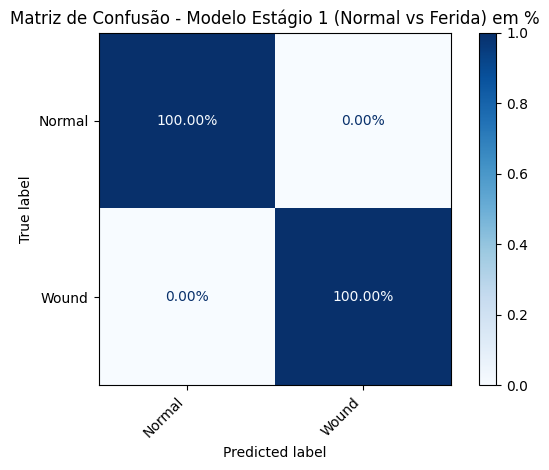


Análise completa (Modelo Estágio 1).


In [9]:
# --- Dataset para Avaliação do Modelo Estágio 1 (Normal vs Ferida) ---
if model_s1 is not None:
    stage1_test_dataset = Stage1ImageTestDataset(test_df_s1, transform=val_test_transforms)
    stage1_test_loader = DataLoader(
        stage1_test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0, 
        collate_fn=collate_fn_skip_errors
    )

    # --- 4. Avaliação do Modelo Estágio 1 (Normal vs Ferida) ---
    print("\n--- Avaliação do Modelo Estágio 1 (Normal vs Ferida) ---")

    y_true_s1 = []
    y_pred_s1 = []

    model_s1.to(device)
    model_s1.eval()

    with torch.no_grad():
        for images, stage1_labels_idx, paths in stage1_test_loader:
            if images.nelement() == 0: continue

            images = images.to(device)
            stage1_labels_idx = stage1_labels_idx.cpu().numpy()
            y_true_s1.extend(stage1_labels_idx)

            outputs_s1 = model_s1(images)
            _, preds_s1 = torch.max(outputs_s1, 1)

            y_pred_s1.extend(preds_s1.cpu().numpy())

    y_true_s1 = np.array(y_true_s1)
    y_pred_s1 = np.array(y_pred_s1)

    if len(y_true_s1) == 0:
        print("Nenhuma amostra processada para avaliação do Estágio 1.")
    else:
        report_dict_s1 = classification_report(
            y_true_s1,
            y_pred_s1,
            target_names=classes_s1,
            output_dict=True, 
            zero_division=0
        )

        metrics_data = {}
        for class_name in classes_s1:
            metrics_data[class_name] = {
                'Precision': report_dict_s1[class_name]['precision'],
                'Recall': report_dict_s1[class_name]['recall'],
                'F1-score': report_dict_s1[class_name]['f1-score'],
                'Support': report_dict_s1[class_name]['support']
            }

        metrics_df_s1 = pd.DataFrame.from_dict(metrics_data, orient='index')

        print("\nMétricas por Classe:")
        print(metrics_df_s1.to_string(float_format='%.4f'))


        # --- Matriz de Confusão (Normal vs Ferida) em Porcentagem ---
        cm_s1 = confusion_matrix(y_true_s1, y_pred_s1, labels=list(range(len(classes_s1))))

        row_sums_s1 = np.sum(cm_s1, axis=1, keepdims=True)
        cm_s1_normalized = np.where(row_sums_s1 > 0, cm_s1.astype('float') / row_sums_s1, 0)

        disp_s1 = ConfusionMatrixDisplay(confusion_matrix=cm_s1_normalized, display_labels=classes_s1)
        disp_s1.plot(cmap=plt.cm.Blues, values_format='.2%')
        plt.title("Matriz de Confusão - Modelo Estágio 1 (Normal vs Ferida) em %")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

else:
    print("\nModelo Estágio 1 (original) não carregado. Pulando avaliação do Modelo Estágio 1.")

print("\nAnálise completa (Modelo Estágio 1).")

### Estágio 2 (Feridas)

In [10]:
# --- Carregar Modelo Original Estágio 2 Treinado ---
model_s2 = None

if 'test_df_s2' in globals() and not test_df_s2.empty and 'classes_s2' in globals():
    if os.path.exists("modelo_estagio2_semAugmentation.pth"):
        try:
            model_s2 = get_model(num_classes=len(classes_s2), model_name='resnet50')
            model_s2.load_state_dict(torch.load("modelo_estagio2_semAugmentation.pth", map_location=device))
            model_s2.eval()
            print("\nModelo Estágio 2 (original) carregado para avaliação.")
        except Exception as e:
            print(f"\nErro ao carregar modelo_estagio2_semAugmentation.pth: {e}")
            model_s2 = None
    else:
        print("\nArquivo modelo_estagio2_semAugmentation.pth não encontrado. Pulando avaliações do Modelo Estágio 2.")
else:
     print("\nDataFrame test_df_s2 ou classes_s2 não definidos/vazios. Pulando avaliações do Modelo Estágio 2.")


# --- Definição do Dataset para Avaliação Geral do Modelo Estágio 2 (Apenas Feridas) ---
class WoundOnlyImageTestDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['image_path']
        wound_label_idx = row['label_s2']

        try:
            image = Image.open(img_path).convert('RGB')
        except (FileNotFoundError, Exception):
            return None, None, None

        if self.transform:
            image = self.transform(image)

        return image, wound_label_idx, img_path


Modelo Estágio 2 (original) carregado para avaliação.



Modelo Estágio 2 (original) carregado para avaliação.

--- Avaliação Geral do Modelo Estágio 2 (Apenas Feridas) ---

Acurácia Geral do Modelo Estágio 2 no Teste: 0.8526

Métricas Gerais do Modelo Estágio 2 (Weighted Average):
  Precision: 0.8555
  Recall: 0.8526
  F1-score: 0.8521
  AUC (Weighted) do Modelo Estágio 2: 0.9565

Métricas por Classe (Apenas Feridas):
                 Precision  Recall  F1-score  Support
Diabetic Wounds     0.7955  0.7609    0.7778  46.0000
Pressure Wounds     0.9273  0.8500    0.8870  60.0000
Venous Wounds       0.8246  0.9400    0.8785  50.0000


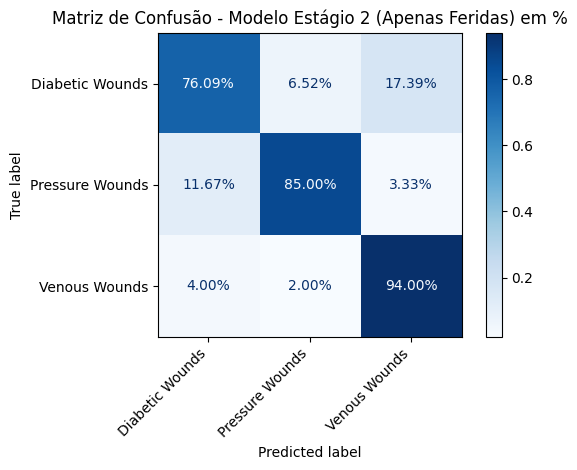


--- Matriz de Confusão por Nível de Confiança (Apenas Feridas) em % ---

Confiança [0.00 - 0.50] (3 amostras):
Acurácia no bin: 0.3333


C:\Users\gabri\AppData\Local\Temp\ipykernel_32240\1734456734.py:206: RuntimeWarning: invalid value encountered in divide
  cm_binned_normalized = np.where(row_sums_binned > 0, cm_binned.astype('float') / row_sums_binned, 0)


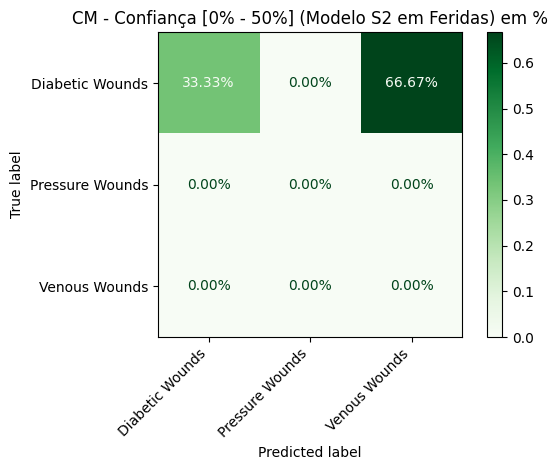


Confiança [0.50 - 0.70] (11 amostras):
Acurácia no bin: 0.4545


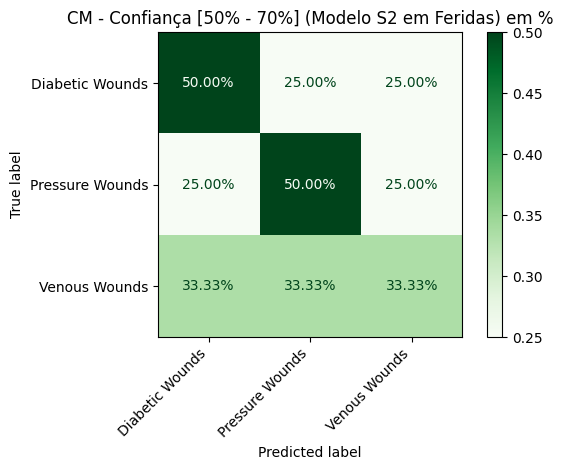


Confiança [0.70 - 0.80] (3 amostras):
Acurácia no bin: 0.3333


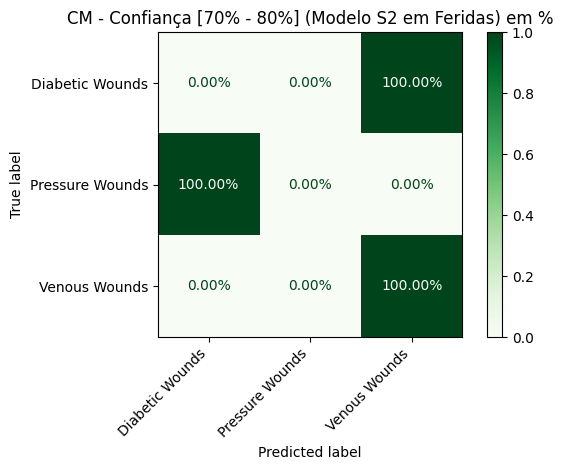


Confiança [0.80 - 0.85] (3 amostras):
Acurácia no bin: 1.0000


C:\Users\gabri\AppData\Local\Temp\ipykernel_32240\1734456734.py:206: RuntimeWarning: invalid value encountered in divide
  cm_binned_normalized = np.where(row_sums_binned > 0, cm_binned.astype('float') / row_sums_binned, 0)


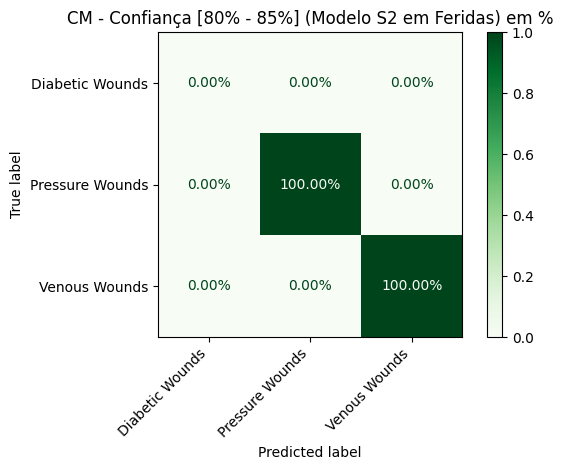


Confiança [0.85 - 0.90] (5 amostras):
Acurácia no bin: 0.6000


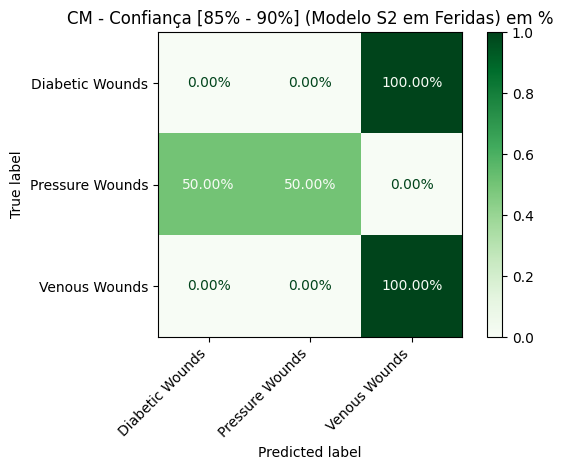


Confiança [0.90 - 0.95] (14 amostras):
Acurácia no bin: 0.8571


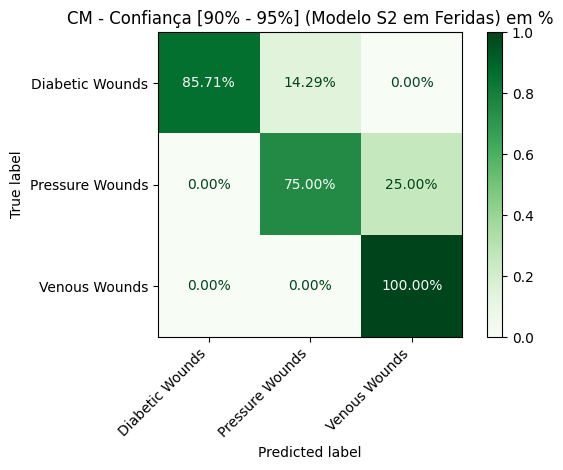


Confiança [0.95 - 1.00] (117 amostras):
Acurácia no bin: 0.9231


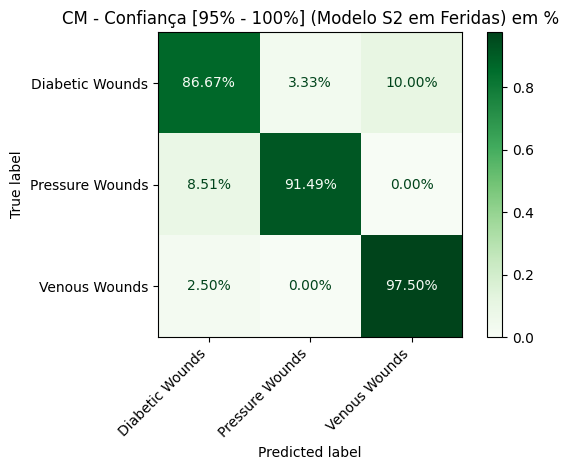


Análise completa (Modelo Estágio 2 Original em Feridas).


In [ ]:
# --- Dataset para Avaliação do Modelo Estágio 2 (Apenas Feridas) ---
if model_s2 is not None:
    wound_only_test_dataset = WoundOnlyImageTestDataset(test_df_s2, transform=val_test_transforms)
    wound_only_test_loader = DataLoader(
        wound_only_test_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn_skip_errors
    )


    # --- 4. Avaliação Geral do Modelo Estágio 2 (Apenas Feridas) ---
    print("\n--- Avaliação Geral do Modelo Estágio 2 (Apenas Feridas) ---")

    y_true_wound_only = []
    y_pred_wound_only = []
    y_pred_probs_wound_only = []
    all_probs_s2 = []

    model_s2.to(device)
    model_s2.eval()

    with torch.no_grad():
        for images, wound_labels_idx, paths in wound_only_test_loader:
            if images.nelement() == 0: continue

            images = images.to(device)
            wound_labels_idx = wound_labels_idx.cpu().numpy()
            y_true_wound_only.extend(wound_labels_idx)

            outputs_s2 = model_s2(images)
            probs_s2 = F.softmax(outputs_s2, dim=1)
            confidence_s2, pred_s2_local_idx = torch.max(probs_s2, 1)

            y_pred_wound_only.extend(pred_s2_local_idx.cpu().numpy())
            y_pred_probs_wound_only.extend(confidence_s2.cpu().numpy())
            all_probs_s2.extend(probs_s2.cpu().numpy())

    y_true_wound_only = np.array(y_true_wound_only)
    y_pred_wound_only = np.array(y_pred_wound_only)
    y_pred_probs_wound_only = np.array(y_pred_probs_wound_only)
    all_probs_s2 = np.array(all_probs_s2)

    # --- CALCULAR E IMPRIMIR A ACURÁCIA GERAL ---
    if len(y_true_wound_only) > 0:
        overall_accuracy_s2 = (y_true_wound_only == y_pred_wound_only).mean()
        print(f"\nAcurácia Geral do Modelo Estágio 2 no Teste: {overall_accuracy_s2:.4f}")
    else:
        print("\nNenhuma amostra processada para avaliação do Estágio 2.")
    # --- FIM DO CALCULO E IMPRESSÃO DA ACURÁCIA GERAL ---

    if len(y_true_wound_only) == 0:
        print("Nenhuma amostra processada para avaliação do Estágio 2.")
    else:
        # --- Gerar Relatório de Classificação como Dicionário ---
        report_dict_s2 = classification_report(
            y_true_wound_only,
            y_pred_wound_only,
            target_names=classes_s2,
            output_dict=True,
            zero_division=0
        )

        # --- IMPRIMIR PRECISÃO, RECALL e F1-SCORE GERAIS (Weighted Avg) ---
        print("\nMétricas Gerais do Modelo Estágio 2 (Weighted Average):")
        print(f"   Precision: {report_dict_s2['weighted avg']['precision']:.4f}")
        print(f"   Recall: {report_dict_s2['weighted avg']['recall']:.4f}")
        print(f"   F1-score: {report_dict_s2['weighted avg']['f1-score']:.4f}")

        # --- CALCULAR E IMPRIMIR AUC ---
        if len(np.unique(y_true_wound_only)) > 1:
            try:
                auc_score_s2 = roc_auc_score(y_true_wound_only, all_probs_s2, multi_class='ovr', average='weighted')
                print(f"   AUC (Weighted) do Modelo Estágio 2: {auc_score_s2:.4f}")
            except ValueError as e:
                print(f"   Não foi possível calcular o AUC: {e}. Isso pode ocorrer se houver apenas uma classe verdadeira nos dados.")
        else:
            print("   Não foi possível calcular o AUC: Apenas uma classe verdadeira encontrada nos dados.")

        # --- Formatar Métricas por Classe em Tabela (DataFrame) ---
        metrics_data_s2 = {}
        for class_name in classes_s2:
            metrics_data_s2[class_name] = {
                'Precision': report_dict_s2[class_name]['precision'],
                'Recall': report_dict_s2[class_name]['recall'],
                'F1-score': report_dict_s2[class_name]['f1-score'],
                'Support': report_dict_s2[class_name]['support']
            }

        metrics_df_s2 = pd.DataFrame.from_dict(metrics_data_s2, orient='index')

        print("\nMétricas por Classe (Apenas Feridas):")
        print(metrics_df_s2.to_string(float_format='%.4f'))


        # --- Matriz de Confusão Padrão (Apenas para classes de feridas) em Porcentagem ---
        cm_wound_only = confusion_matrix(y_true_wound_only, y_pred_wound_only, labels=list(range(len(classes_s2))))

        row_sums = np.sum(cm_wound_only, axis=1, keepdims=True)
        cm_wound_only_normalized = np.where(row_sums > 0, cm_wound_only.astype('float') / row_sums, 0)

        disp_wound_only = ConfusionMatrixDisplay(confusion_matrix=cm_wound_only_normalized, display_labels=classes_s2)
        disp_wound_only.plot(cmap=plt.cm.Blues, values_format='.2%')
        plt.title("Matriz de Confusão - Modelo Estágio 2 (Apenas Feridas) em %")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


    # --- 5. Matriz de Confusão por "Certeza" (Confiança) - Apenas Feridas ---
    print("\n--- Matriz de Confusão por Nível de Confiança (Apenas Feridas) em % ---")
    confidence_bins = np.array([0, 0.5, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0])

    for i in range(len(confidence_bins) - 1):
        low_conf, high_conf = confidence_bins[i], confidence_bins[i+1]

        mask = (y_pred_probs_wound_only >= low_conf) & (y_pred_probs_wound_only < high_conf)
        if high_conf == 1.0:
             mask = (y_pred_probs_wound_only >= low_conf) & (y_pred_probs_wound_only <= high_conf)


        y_true_binned = y_true_wound_only[mask]
        y_pred_binned = y_pred_wound_only[mask]

        if len(y_true_binned) == 0:
            print(f"\nConfiança [{low_conf:.2f} - {high_conf:.2f}]: Sem predições nesta faixa.")
            continue

        print(f"\nConfiança [{low_conf:.2f} - {high_conf:.2f}] ({len(y_true_binned)} amostras):")

        accuracy_binned = np.sum(y_true_binned == y_pred_binned) / len(y_true_binned)
        print(f"Acurácia no bin: {accuracy_binned:.4f}")

        cm_binned = confusion_matrix(y_true_binned, y_pred_binned, labels=list(range(len(classes_s2))))

        row_sums_binned = np.sum(cm_binned, axis=1, keepdims=True)
        cm_binned_normalized = np.where(row_sums_binned > 0, cm_binned.astype('float') / row_sums_binned, 0)

        disp_binned = ConfusionMatrixDisplay(confusion_matrix=cm_binned_normalized, display_labels=classes_s2)
        disp_binned.plot(cmap=plt.cm.Greens, values_format='.2%')
        plt.title(f"CM - Confiança [{low_conf*100:.0f}% - {high_conf*100:.0f}%] (Modelo S2 em Feridas) em %")
        if high_conf == 1.0:
             plt.title(f"CM - Confiança [{low_conf*100:.0f}% - {high_conf*100:.0f}%] (Modelo S2 em Feridas) em %")


        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

else:
    print("\nModelo Estágio 2 (original) não carregado. Pulando todas as avaliações do Modelo Estágio 2.")


print("\nAnálise completa (Modelo Estágio 2 Original em Feridas).")

## Grad-Cam

In [ ]:
# --- 1. Classe para implementar o Grad-CAM ---
class GradCAM:
    """
    Classe para extrair ativações e gradientes e gerar o mapa de calor Grad-CAM.
    AGORA TAMBÉM RETORNA A CONFIANÇA DA PREDIÇÃO.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, x, class_idx=None):
        output = self.model(x)

        # --- MUDANÇA AQUI: Captura a confiança da predição ---
        probs = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probs, 1)

        if class_idx is None:
            class_idx = predicted_class.item()

        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0][class_idx] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.shape[2], x.shape[3]))
        cam -= np.min(cam)
        cam /= np.max(cam)

        # Retorna também a confiança
        return cam, class_idx, confidence.item()


# --- Função para Visualização (VERSÃO FINAL) ---
# Agora, o blur é controlado por uma lista de nomes de classes.
def visualize_grad_cam(model, target_layer, dataset, image_index, class_names, blur_radius=10, classes_to_blur=None):
    """
    Gera e exibe a imagem original e o Grad-CAM.
    Aplica blur se a classe verdadeira da imagem estiver na lista 'classes_to_blur'.
    """
    # Define uma lista vazia como padrão se nenhuma for passada
    if classes_to_blur is None:
        classes_to_blur = []
        
    model.eval()
    normalized_tensor, true_label_idx, img_path = dataset[image_index]
    normalized_tensor = normalized_tensor.unsqueeze(0).to(device)

    # Carrega a imagem original
    original_pil_img = Image.open(img_path).convert('RGB').resize((224, 224))
    
    # Obtém o nome da classe verdadeira
    true_label_name = class_names[true_label_idx]
    
    # --- MUDANÇA AQUI: Aplica blur com base na classe da imagem ---
    display_img = original_pil_img
    title_suffix = "(Nítida)"
    if true_label_name in classes_to_blur:
        display_img = original_pil_img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
        title_suffix = "(com Blur)"

    # O restante da função permanece igual
    display_np_img = np.array(display_img)
    display_np_img = cv2.cvtColor(display_np_img, cv2.COLOR_RGB2BGR)

    grad_cam_extractor = GradCAM(model, target_layer)
    heatmap, predicted_idx, confidence = grad_cam_extractor(normalized_tensor)
    
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(display_np_img, 0.6, heatmap_colored, 0.4, 0)
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    predicted_label_name = class_names[predicted_idx]
    
    # Imprime a predição e a confiança no console
    print(f"Classe Predita: {predicted_label_name}")
    print(f"Confiança (Certeza): {confidence:.2%}")
    print("-" * 30)

    # Exibe as imagens
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(display_img)
    ax1.set_title(f"Imagem Original {title_suffix}\nClasse Verdadeira: {true_label_name}")
    ax1.axis('off')
    ax2.imshow(superimposed_img)
    ax2.set_title(f"Grad-CAM\nClasse Predita: {predicted_label_name}")
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

Modelo Estágio 2 carregado com sucesso.
Dataset de teste criado com 156 imagens.

--- Gerando Grad-CAM para a instância 14 da classe: Diabetic Wounds ---


c:\Users\gabri\OneDrive\Documentos\WoundsDataset\venv_wound\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Classe Predita: Diabetic Wounds
Confiança (Certeza): 99.50%
------------------------------


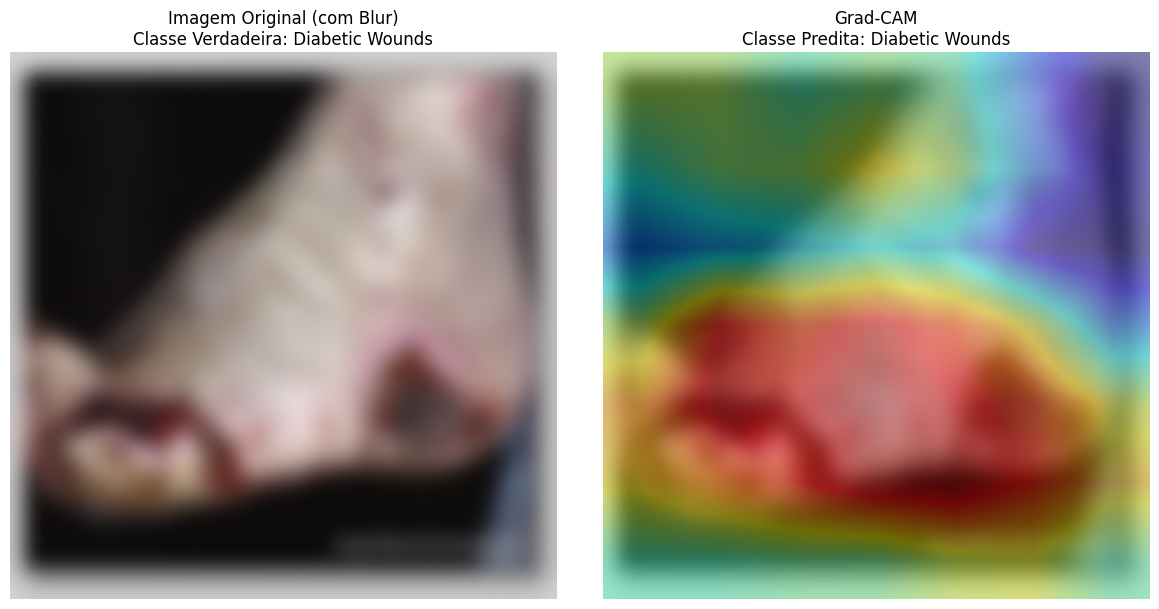


--- Gerando Grad-CAM para a instância 54 da classe: Pressure Wounds ---
Classe Predita: Pressure Wounds
Confiança (Certeza): 90.13%
------------------------------


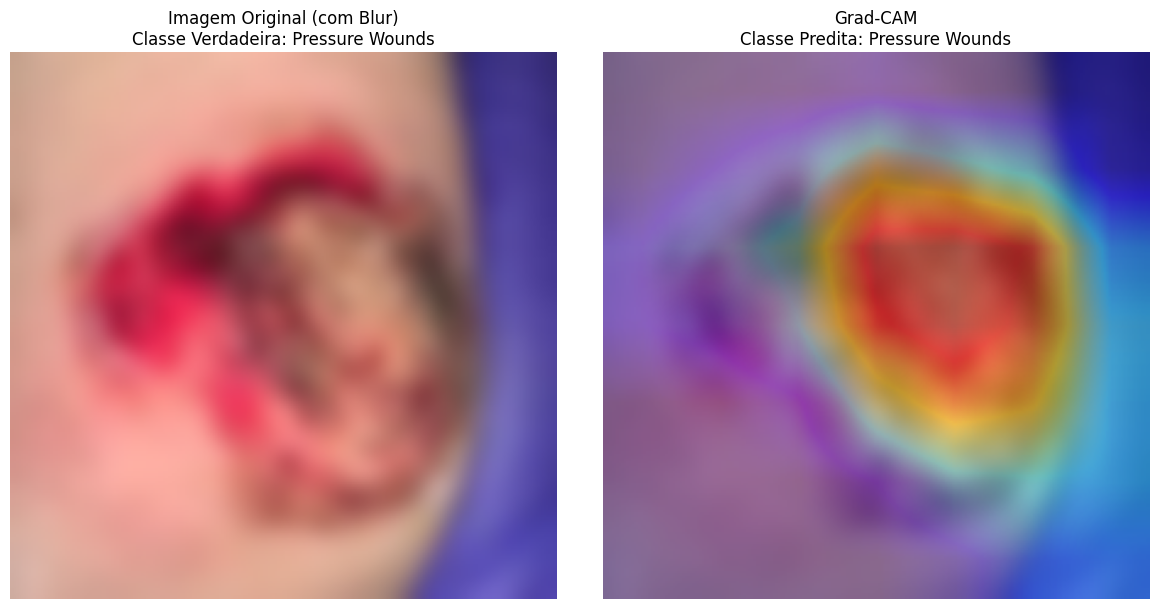


--- Gerando Grad-CAM para a instância 1 da classe: Venous Wounds ---
Classe Predita: Venous Wounds
Confiança (Certeza): 100.00%
------------------------------


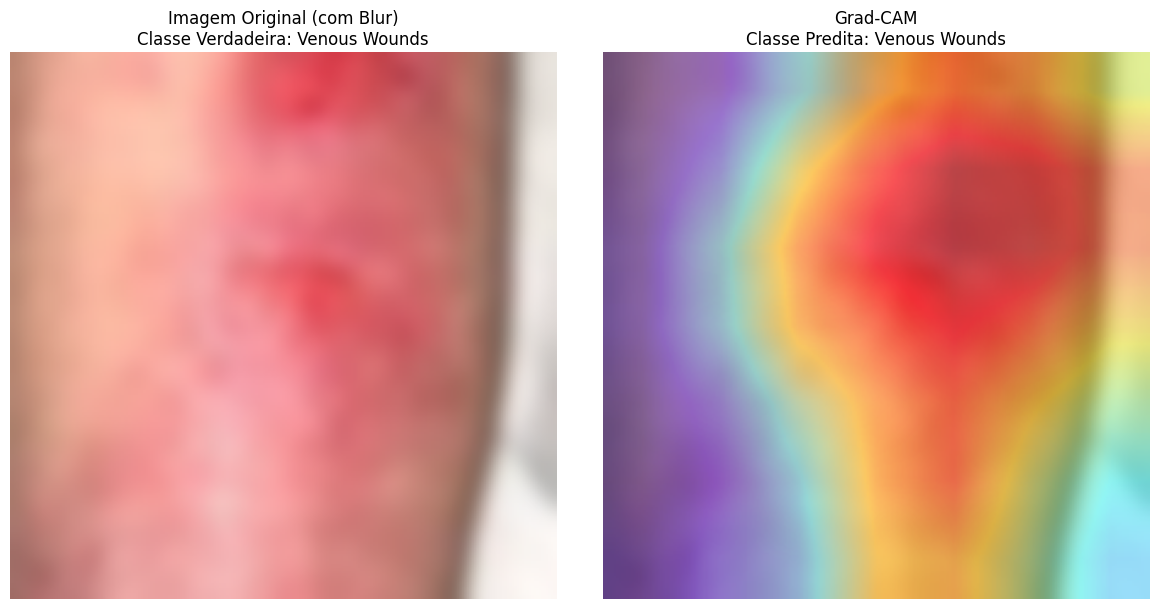

In [47]:
### --- 3. Configuração e Carregamento --- ###
try:
    model_s2 = get_model(num_classes=len(classes_s2), model_name='resnet50')
    model_s2.load_state_dict(torch.load("modelo_estagio2_semAugmentation.pth", map_location=device))
    model_s2.to(device)
    print("Modelo Estágio 2 carregado com sucesso.")

    wound_only_test_dataset = WoundOnlyImageTestDataset(test_df_s2, transform=val_test_transforms)
    print(f"Dataset de teste criado com {len(wound_only_test_dataset)} imagens.")

except NameError as e:
    print(f"Erro: Uma variável ou função necessária não foi definida. Rode as células anteriores. Detalhe: {e}")
except FileNotFoundError:
    print("Erro: Arquivo 'modelo_estagio2_semAugmentation.pth' não encontrado.")


### --- 4. Execução do Grad-CAM por Classe (Mantido) --- ###

if 'model_s2' in locals() and 'wound_only_test_dataset' in locals():
    target_layer_s2 = model_s2.layer4
    blur_amount = 4
    
    classes_para_blur_s2 = ['Diabetic Wounds', 'Pressure Wounds', 'Venous Wounds']

    # --- ESCOLHA A INSTÂNCIA DE CADA CLASSE AQUI ---
    instances_to_show = {
        'Diabetic Wounds': 13,
        'Pressure Wounds': 53,
        'Venous Wounds': 0,
    }

    for class_name, instance_idx in instances_to_show.items():
        print(f"\n--- Gerando Grad-CAM para a instância {instance_idx + 1} da classe: {class_name} ---")

        try:
            class_df = test_df_s2[test_df_s2['label_name'] == class_name]

            if instance_idx >= len(class_df):
                print(f"AVISO: O índice de instância {instance_idx} está fora do alcance para a classe '{class_name}'. "
                      f"Existem apenas {len(class_df)} amostras desta classe no conjunto de teste. Pulando.")
                continue

            original_index = class_df.index[instance_idx]
            dataset_index = test_df_s2.index.get_loc(original_index)

            visualize_grad_cam(
                model=model_s2,
                target_layer=target_layer_s2,
                dataset=wound_only_test_dataset,
                image_index=dataset_index,
                class_names=classes_s2,
                blur_radius=blur_amount,
                classes_to_blur=classes_para_blur_s2
            )
        except Exception as e:
            print(f"Ocorreu um erro ao processar a classe {class_name}: {e}")
else:
    print("\nModelo ou dataset não foram carregados. Análise Grad-CAM não pode ser executada.")


--- Gerando Grad-CAM para a instância 1 da classe: Normal ---
Classe Predita: Normal
Confiança (Certeza): 100.00%
------------------------------


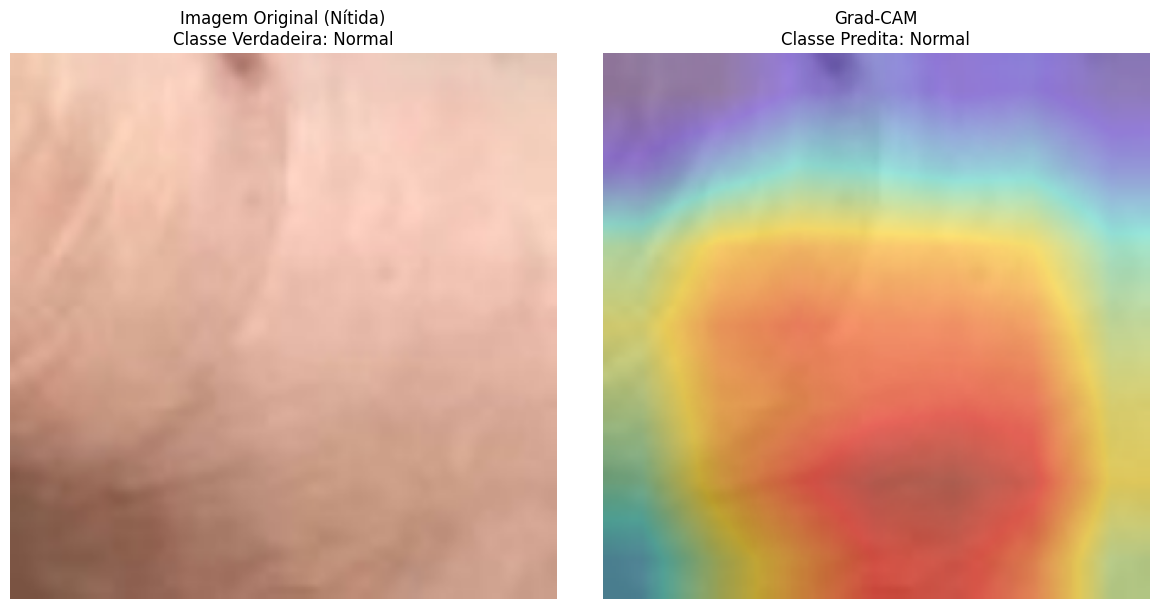


--- Gerando Grad-CAM para a instância 6 da classe: Wound ---
Classe Predita: Wound
Confiança (Certeza): 99.84%
------------------------------


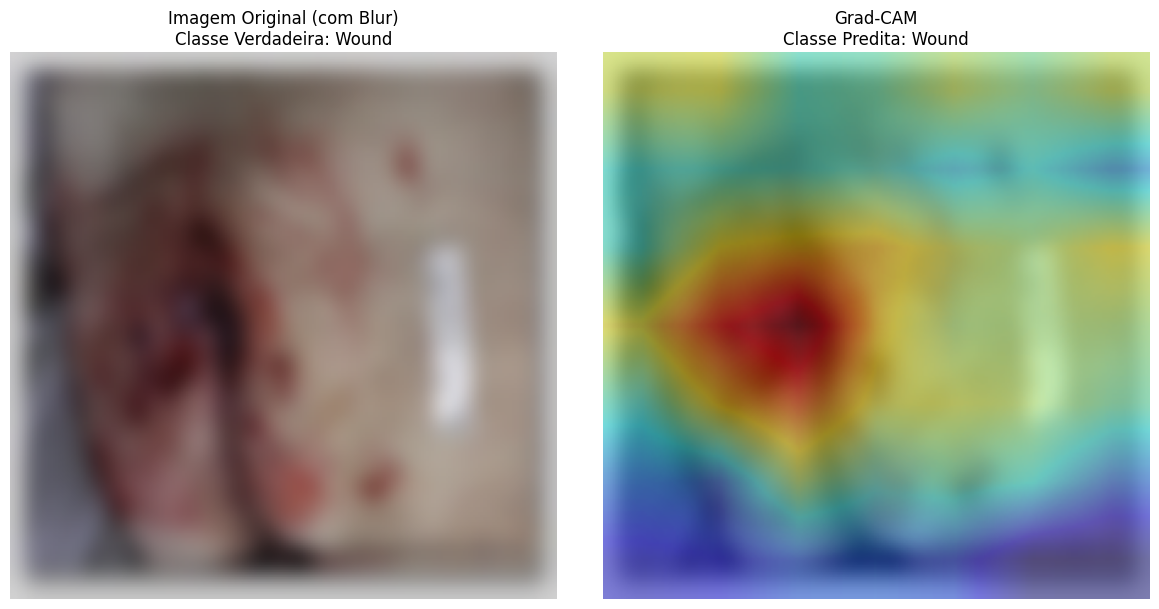

In [49]:
### --- Execução do Grad-CAM para Estágio 1 --- ###

if 'model_s1' in locals() and 'test_dataset_s1' in locals():
    target_layer_s1 = model_s1.layer4
    blur_amount = 4
    
    # --- DEFINA AQUI QUAIS CLASSES RECEBERÃO O BLUR ---
    classes_para_blur_s1 = ['Wound']

    # --- ESCOLHA A INSTÂNCIA DE CADA CLASSE AQUI ---
    normal_instance_to_visualize = 0
    wound_instance_to_visualize = 5

    instances_s1_to_show = {
        'Normal': (0, normal_instance_to_visualize), 
        'Wound':  (1, wound_instance_to_visualize)
    }

    for class_name, (label_idx, instance_idx) in instances_s1_to_show.items():
        print(f"\n--- Gerando Grad-CAM para a instância {instance_idx + 1} da classe: {class_name} ---")
        try:
            class_df = test_df_s1[test_df_s1['label_s1'] == label_idx]
            if instance_idx >= len(class_df):
                print(f"AVISO: Índice de instância fora do alcance para '{class_name}'. Pulando.")
                continue

            original_index = class_df.index[instance_idx]
            dataset_index = test_df_s1.index.get_loc(original_index)

            # Chama a função passando a lista de classes para o blur
            visualize_grad_cam(
                model=model_s1,
                target_layer=target_layer_s1,
                dataset=test_dataset_s1,
                image_index=dataset_index,
                class_names=classes_s1,
                blur_radius=blur_amount,
                classes_to_blur=classes_para_blur_s1 # Passa a lista aqui
            )
        except Exception as e:
            print(f"Ocorreu um erro ao processar a classe {class_name}: {e}")
else:
    print("\nModelo ou dataset do Estágio 1 não carregados.")